In [1]:
import math

import random as rd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.collections as mc

In [2]:
SEED = 1
rd.seed(SEED)

In [3]:
def generate_data(count):
    x = []
    y = []

    for i in range(0, count):
        x.append(rd.randrange(1000)/100.0)
        y.append(rd.randrange(1000)/100.0)

    return pd.DataFrame({'x': x, 'y': y})

,x,y
0,1.37,5.82
1,8.67,8.21
2,7.82,0.64
3,2.61,1.20
4,5.07,7.79
5,4.60,4.83
6,6.67,3.88
7,8.07,2.14
8,0.96,4.99
9,0.29,9.14


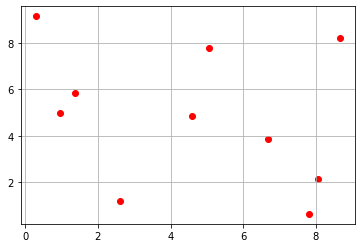

In [4]:
npoints = 10

points = generate_data(npoints)
plt.scatter(points['x'], points['y'], c='r')
plt.grid(True)
points

In [5]:
points.to_csv("points.csv")

In [6]:
points = pd.read_csv("points.csv", index_col=0)
points

,x,y
0,1.37,5.82
1,8.67,8.21
2,7.82,0.64
3,2.61,1.20
4,5.07,7.79
5,4.60,4.83
6,6.67,3.88
7,8.07,2.14
8,0.96,4.99
9,0.29,9.14


In [7]:
def get_edge_ids():
    if SEED == 1:
        return pd.DataFrame({
            'start':[0, 0, 4, 4, 6, 6, 2, 2],
            'end'  :[9, 8, 5, 1, 5, 1, 3, 7]
        })

def get_adj_list(edge_ids):
    ret = {}
    
    for edge in edge_ids:
        if edge[0] not in ret:
            ret[edge[0]] = []
        ret[edge[0]].append(edge[1])
        
        if edge[1] not in ret:
            ret[edge[1]] = []
        ret[edge[1]].append(edge[2])
    
    return ret
    
edge_ids = get_edge_ids()
edge_ids

,start,end
0,0,9
1,0,8
2,4,5
3,4,1
4,6,5
5,6,1
6,2,3
7,2,7


In [8]:
def generate_edge_point(i, j):
    return [
        [points['x'][i], points['x'][j]],
        [points['y'][i], points['y'][j]]
    ]

def generate_edge_point_raw(p1, p2):
    return [
        [p1[0], p2[0]],
        [p1[1], p2[1]]
    ]

In [9]:
def get_angle(point):
    x = point[0]
    y = point[1]
    size = math.sqrt(x*x + y*y)
    angle = math.acos(x/size)*180/math.pi
    
    if y < 0:
        angle = 360 - angle
        
    return angle

In [10]:
def normalize_vector(point):
    x = point[0]
    y = point[1]
    size = math.sqrt(x*x + y*y)
    return [x/size, y/size]

In [11]:
def add_vector_to_point(point, vector, size):
    vector = normalize_vector(vector)
    return [point[0] + vector[0]*size, point[1] + vector[1]*size]

In [12]:
def rotate_point(base, point, angle):
    s = math.sin(angle*math.pi/180)
    c = math.cos(angle*math.pi/180)
    
    x = point[0] - base[0]
    y = point[1] - base[1]
    
    return [
        x*c - y*s + base[0],
        x*s + y*c + base[1]
    ]

In [13]:
def normalize_angle(start, end, angle):
    if(angle >= start) and angle <= end:
        return angle
    else:
        return angle - 360

In [14]:
def check_in_angle_range(start, end, angle):
    if (angle >= start) and (angle <= end):
        return True
    
    angle = angle - 360
    
    if (angle >= start) and (angle <= end):
        return True
    
    return False

In [15]:
def get_line(p1, p2):
    m = (p2[1] - p1[1])/(p2[0] - p1[0])
    return [m, -1, p1[1] - m*p1[0]]

In [16]:
def get_distance(line, point):
    num = line[0]*point[0] + line[1]*point[1] + line[3]
    if num < -1:
        num = num*(-1)
    
    den = math.sqrt(line[0]*line[0] + line[1]*line[1])
    
    return num/den

In [17]:
def get_distance_points(p1, p2):
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    
    return math.sqrt(dx*dx + dy*dy)

In [18]:
def get_perp_distance_points(p1, p2, point):
    return get_distance(get_line(p1, p2), point)

In [19]:
DATA_POINT_COLOR_DEFAULT = 'lightblue'
DATA_POINT_COLOR_SEMI = 'blue'
DATA_POINT_COLOR_VIEW = 'black'

DATA_EDGE_COLOR_DEFAULT = 'lightblue'
DATA_EDGE_COLOR_SEMI = 'blue'
DATA_EDGE_COLOR_VIEW = 'black'

ORIGIN_COLOR = 'lime'
VIEWPOINT_COLOR = 'orange'
VIEWPOINT_EDGE_COLOR = 'orange'

AXIS_POINT_COLOR = 'lightgreen'
AXIS_EDGE_COLOR = 'lightgreen'

In [20]:
FOV = 70
RADIUS = 4.5

ORIGIN = [4, 4.5]
DIRECTION = [1, 1]

base_angle = get_angle(DIRECTION)

viewpoint = add_vector_to_point(ORIGIN, DIRECTION, RADIUS)

viewpoint_begin = rotate_point(ORIGIN, viewpoint, FOV/2)
viewpoint_end = rotate_point(ORIGIN, viewpoint, -FOV/2)

axis_xp = rotate_point(ORIGIN, viewpoint, -90)
axis_xn = rotate_point(ORIGIN, viewpoint, 90)

In [21]:
def tag_points():
    colors = [DATA_POINT_COLOR_DEFAULT]*len(points)
    normalized_angles = []

    reference_angle = get_angle(DIRECTION)
    semicircle_angle_start = reference_angle - 90
    semicircle_angle_end = reference_angle + 90
    fov_angle_start = reference_angle - FOV/2
    fov_angle_end = reference_angle + FOV/2

    for index, row in points.iterrows():
        angle = get_angle([row['x'] - ORIGIN[0], row['y'] - ORIGIN[1]])
        normalized_angles.append(normalize_angle(semicircle_angle_start, semicircle_angle_end, angle))

        if(check_in_angle_range(fov_angle_start, fov_angle_end, angle)):
            colors[index] = DATA_POINT_COLOR_VIEW
        elif check_in_angle_range(semicircle_angle_start, semicircle_angle_end, angle):
            colors[index] = DATA_POINT_COLOR_SEMI
    
    points['color'] = colors
    points['normalized_angle'] = normalized_angles

tag_points()
print(points)

      x     y      color  normalized_angle
0  1.37  5.82  lightblue       -206.652127
1  8.67  8.21      black         38.464772
2  7.82  0.64  lightblue        -45.298413
3  2.61  1.20  lightblue       -112.841416
4  5.07  7.79      black         71.984026
5  4.60  4.83      black         28.810794
6  6.67  3.88       blue        -13.072954
7  8.07  2.14       blue        -30.107412
8  0.96  4.99  lightblue       -189.156421
9  0.29  9.14       blue        128.644746


In [22]:
points_filtered = points[points['color'] != DATA_POINT_COLOR_DEFAULT]
print(points_filtered)

      x     y  color  normalized_angle
1  8.67  8.21  black         38.464772
4  5.07  7.79  black         71.984026
5  4.60  4.83  black         28.810794
6  6.67  3.88   blue        -13.072954
7  8.07  2.14   blue        -30.107412
9  0.29  9.14   blue        128.644746


In [23]:
def tag_edges():
    colors = [DATA_EDGE_COLOR_DEFAULT]*len(edge_ids)
    return colors

edge_colors = tag_edges()

In [24]:
def plot_point(point, color, text=""):
    plt.scatter(point[0], point[1], c=color)
    plt.text(point[0] + 0.1, point[1] + 0.1, text)

In [25]:
def plot_edge(p1, p2, color, text=""):
    p = generate_edge_point_raw(p1, p2)
    plt.plot(p[0], p[1], linestyle="--", c=color)
    plt.text((p1[0] + p2[0])/2 + 0.1, (p1[1] + p2[1])/2 + 0.1, text)

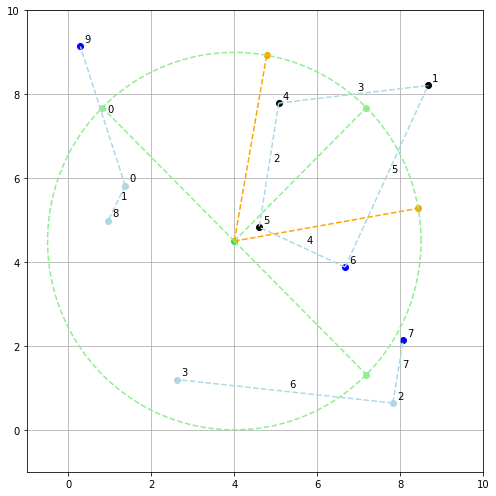

In [26]:
def plot_situation():
    plt.rcParams["figure.autolayout"] = True

    # Plot the building edges
    for index, edge_id in edge_ids.iterrows():
        plot_edge(points.iloc[edge_id[0]], points.iloc[edge_id[1]], edge_colors[index], index)

    # Plot the points
    for index, row in points.iterrows():
        plot_point([row['x'], row['y']], row['color'], index)

    # Plot the origin
    plt.scatter(ORIGIN[0], ORIGIN[1], c=ORIGIN_COLOR)

    # Plot the point of view
    plot_point(viewpoint, AXIS_POINT_COLOR)
    plot_point(viewpoint_begin, VIEWPOINT_COLOR)
    plot_point(viewpoint_end, VIEWPOINT_COLOR)
    plot_point(axis_xp, AXIS_POINT_COLOR)
    plot_point(axis_xn, AXIS_POINT_COLOR)
    
    plot_edge(ORIGIN, viewpoint, AXIS_EDGE_COLOR)
    plot_edge(ORIGIN, viewpoint_begin, VIEWPOINT_EDGE_COLOR)
    plot_edge(ORIGIN, viewpoint_end, VIEWPOINT_EDGE_COLOR)
    plot_edge(ORIGIN, axis_xp, AXIS_EDGE_COLOR)
    plot_edge(ORIGIN, axis_xn, AXIS_EDGE_COLOR)
    
    angle = np.linspace(0, 2*math.pi, 150) 

    x = RADIUS*np.cos(angle) + ORIGIN[0]
    y = RADIUS*np.sin(angle) + ORIGIN[1]

    plt.plot(x, y, linestyle="--", c=AXIS_EDGE_COLOR)
    
    plt.grid(True)
    plt.xlim(-1, 10)
    plt.ylim(-1, 10)

    fig = plt.gcf()
    fig.set_size_inches(7,7)
    plt.show()
    
plot_situation()

In [27]:
def check_edge_overlap(e1, e2, origin):
    # First check angle subset
    angle_1 = [points['normalized_angle'][edge_ids.iloc[e1]['start']], 
               points['normalized_angle'][edge_ids.iloc[e1]['end']]]
    
    angle_2 = [points['normalized_angle'][edge_ids.iloc[e2]['start']], 
               points['normalized_angle'][edge_ids.iloc[e2]['end']]]
    
    angle_1.sort()
    angle_2.sort()
    
    angle_overlap = (angle_1[0] <= angle_2[0]) and (angle_1[1] >= angle_2[1])

    print()
    print(angle_1, " ", angle_2, " ", angle_overlap)
    
    # Now check distance min
    min_1 = min(
        get_distance_points(
            [
                points['x'][edge_ids.iloc[e1]['start']], 
                points['y'][edge_ids.iloc[e1]['start']]
            ], origin),
        get_distance_points(
            [
                points['x'][edge_ids.iloc[e1]['end']], 
                points['y'][edge_ids.iloc[e1]['end']]
            ], origin)
    )
    
    min_2 = min(
        get_distance_points(
            [
                points['x'][edge_ids.iloc[e2]['start']], 
                points['y'][edge_ids.iloc[e2]['start']]
            ], origin),
        get_distance_points(
            [
                points['x'][edge_ids.iloc[e2]['end']], 
                points['y'][edge_ids.iloc[e2]['end']]
            ], origin)
    )
    
    distance_check = min_1 <= min_2
    
    print(min_1, " ", min_2, " ", distance_check)
    
    return angle_overlap and distance_check
    

checks = [[2, 4, False], [4, 2, False], [2, 3, True], [3, 2, False], [5, 4, False], [4, 5, False]]
for check in checks:
    print("Got: ", check_edge_overlap(check[0], check[1], ORIGIN))
    print("Expected: ", check[2])


[28.810793742973075, 71.9840256433407]   [-13.072953876700808, 28.810793742973075]   False
0.6847627326307993   0.6847627326307993   True
Got:  False
Expected:  False

[-13.072953876700808, 28.810793742973075]   [28.810793742973075, 71.9840256433407]   False
0.6847627326307993   0.6847627326307993   True
Got:  False
Expected:  False

[28.810793742973075, 71.9840256433407]   [38.46477231359747, 71.9840256433407]   True
0.6847627326307993   3.4596242570545144   True
Got:  True
Expected:  True

[38.46477231359747, 71.9840256433407]   [28.810793742973075, 71.9840256433407]   False
3.4596242570545144   0.6847627326307993   False
Got:  False
Expected:  False

[-13.072953876700808, 38.46477231359747]   [-13.072953876700808, 28.810793742973075]   True
2.7410399486326353   0.6847627326307993   False
Got:  False
Expected:  False

[-13.072953876700808, 28.810793742973075]   [-13.072953876700808, 38.46477231359747]   False
0.6847627326307993   2.7410399486326353   True
Got:  False
Expected:  Fals